In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

Y_df = Y_df.reset_index().melt(var_name='unique_id', id_vars='Date', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027935
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


In [4]:
# Contar NaNs por unique_id
nan_counts = Y_df.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


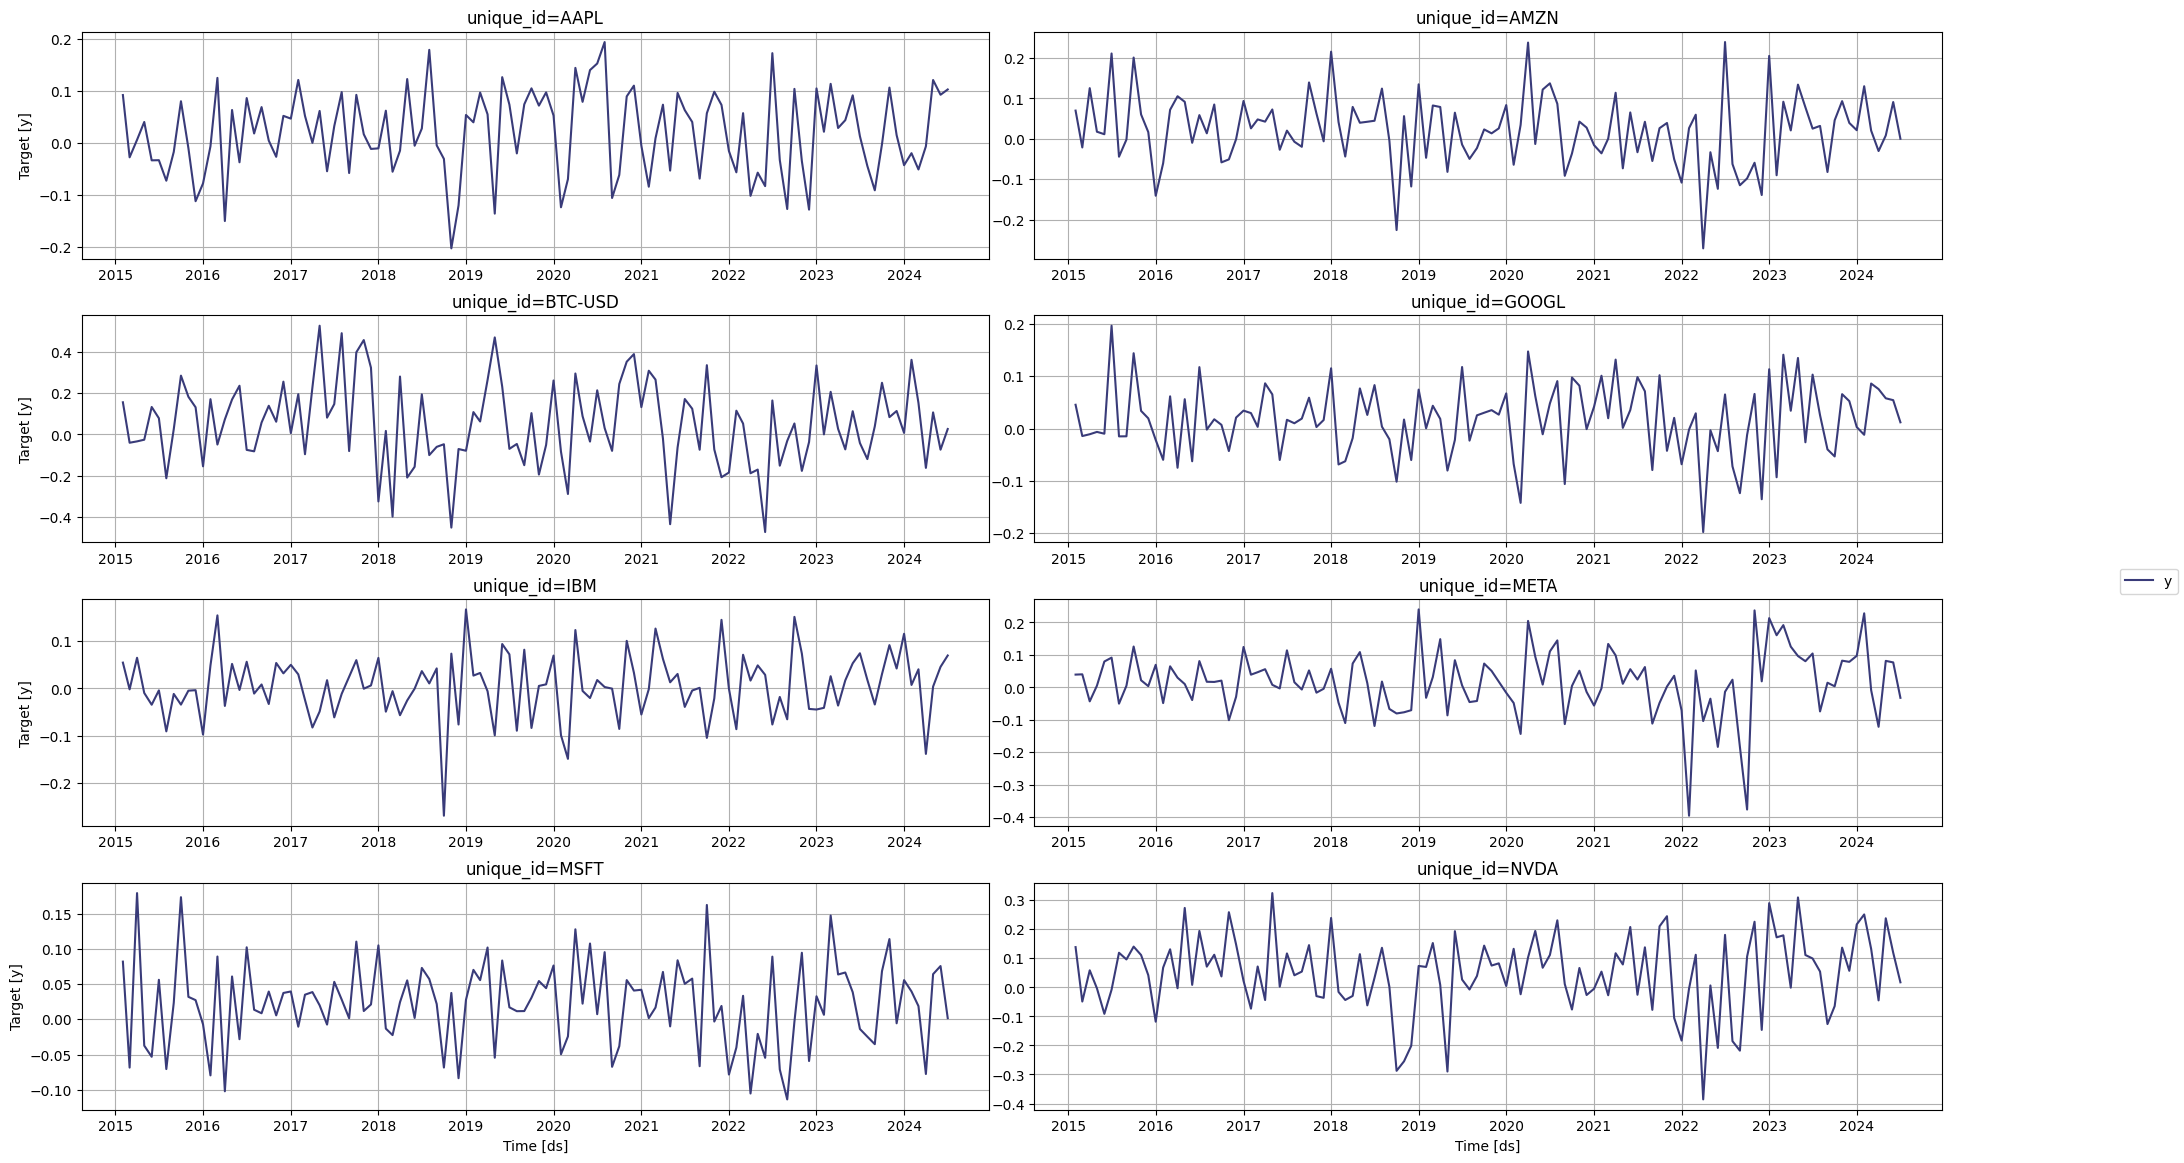

In [5]:
StatsForecast.plot(Y_df, plot_random = False)

In [6]:
season_length = 12
models = [
    AutoARIMA(season_length=season_length)
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [7]:
horizon = 3
levels = [99] 

fcst = sf.forecast(df=Y_df, h = horizon, level = levels, fitted = True)
fcst = fcst.reset_index()
fcst.head()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
0,AAPL,2024-08-01,0.0,-0.212103,0.212103
1,AAPL,2024-09-01,0.0,-0.212103,0.212103
2,AAPL,2024-10-01,0.0,-0.212103,0.212103
3,AMZN,2024-08-01,0.0,-0.230997,0.230997
4,AMZN,2024-09-01,0.0,-0.230997,0.230997


In [8]:
insample_forecasts = sf.forecast_fitted_values().reset_index()
insample_forecasts.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
0,AAPL,2015-02-01,0.092077,0.0,-0.212103,0.212103
1,AAPL,2015-03-01,-0.027935,0.0,-0.212103,0.212103
2,AAPL,2015-04-01,0.005770,0.0,-0.212103,0.212103
3,AAPL,2015-05-01,0.040173,0.0,-0.212103,0.212103
4,AAPL,2015-06-01,-0.033770,0.0,-0.212103,0.212103


In [9]:
anomalies = insample_forecasts.loc[(insample_forecasts['y'] >= insample_forecasts['AutoARIMA-hi-99']) | (insample_forecasts['y'] <= insample_forecasts['AutoARIMA-lo-99'])]
anomalies.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
176,AMZN,2020-04-01,0.238150,0.0,-0.230997,0.230997
200,AMZN,2022-04-01,-0.271186,0.0,-0.230997,0.230997
203,AMZN,2022-07-01,0.239486,0.0,-0.230997,0.230997
347,GOOGL,2015-07-01,0.196802,0.0,-0.180904,0.180904
428,GOOGL,2022-04-01,-0.197801,0.0,-0.180904,0.180904


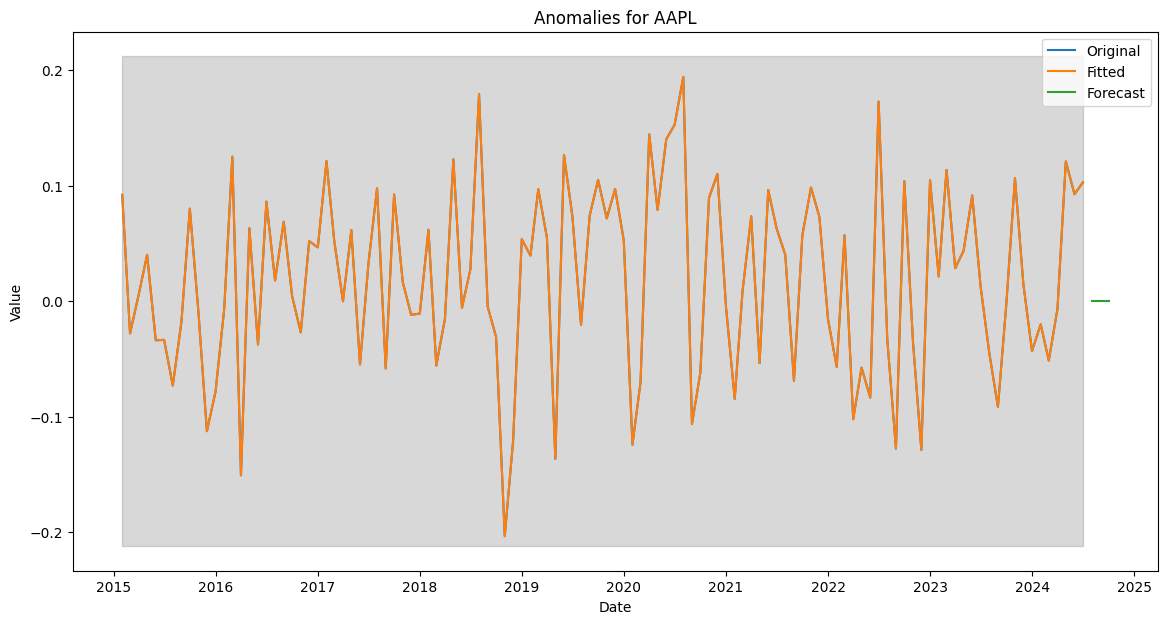

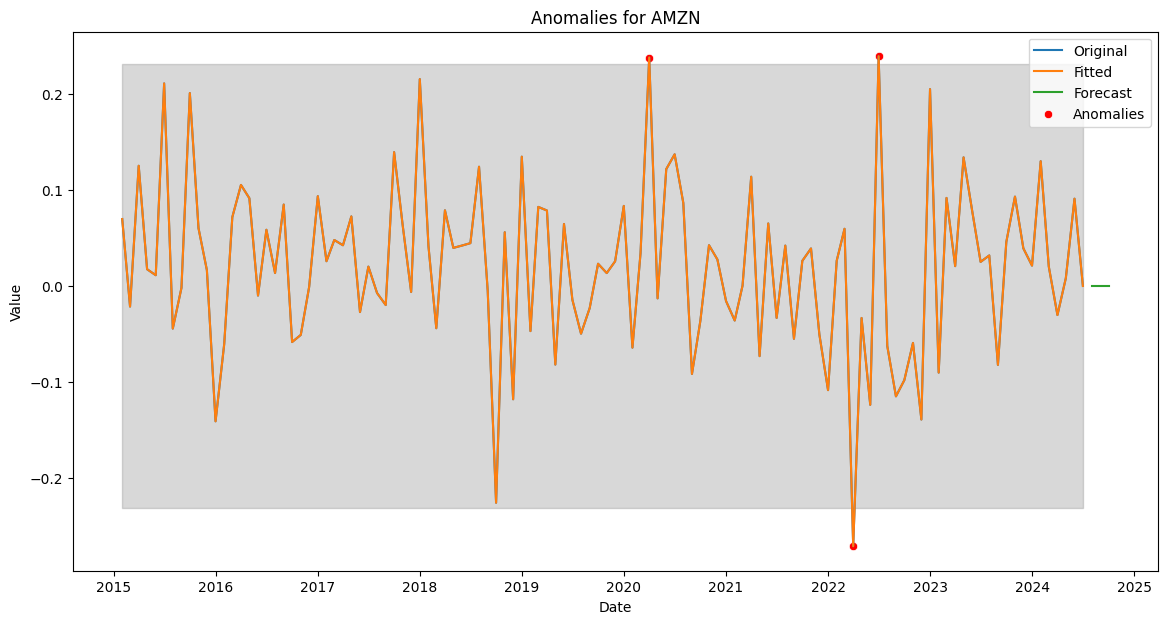

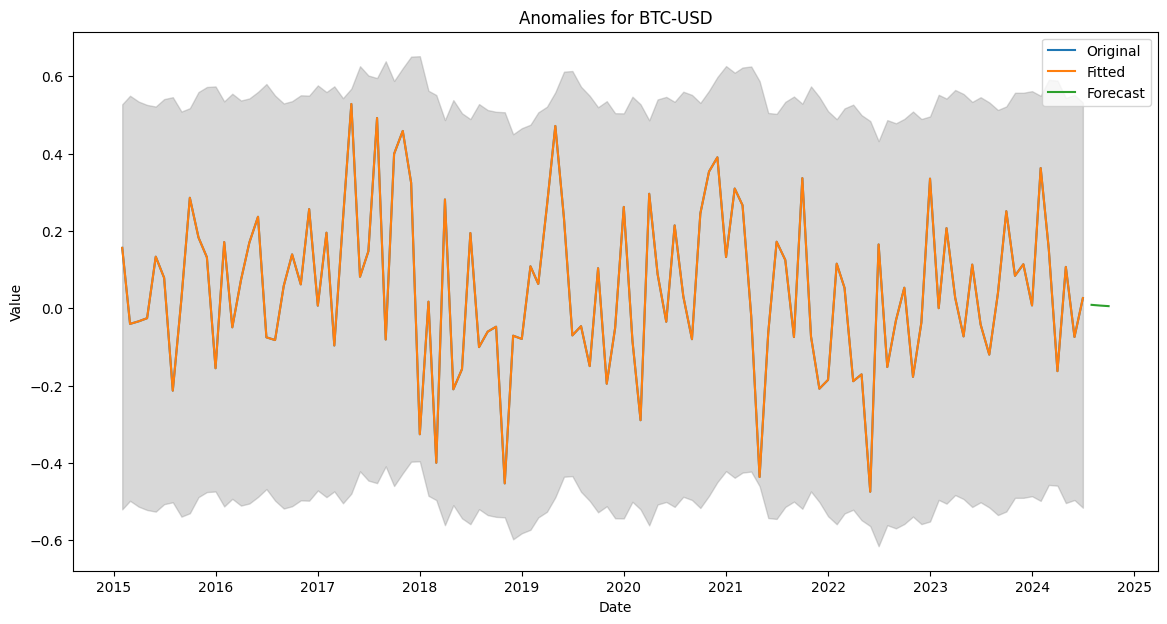

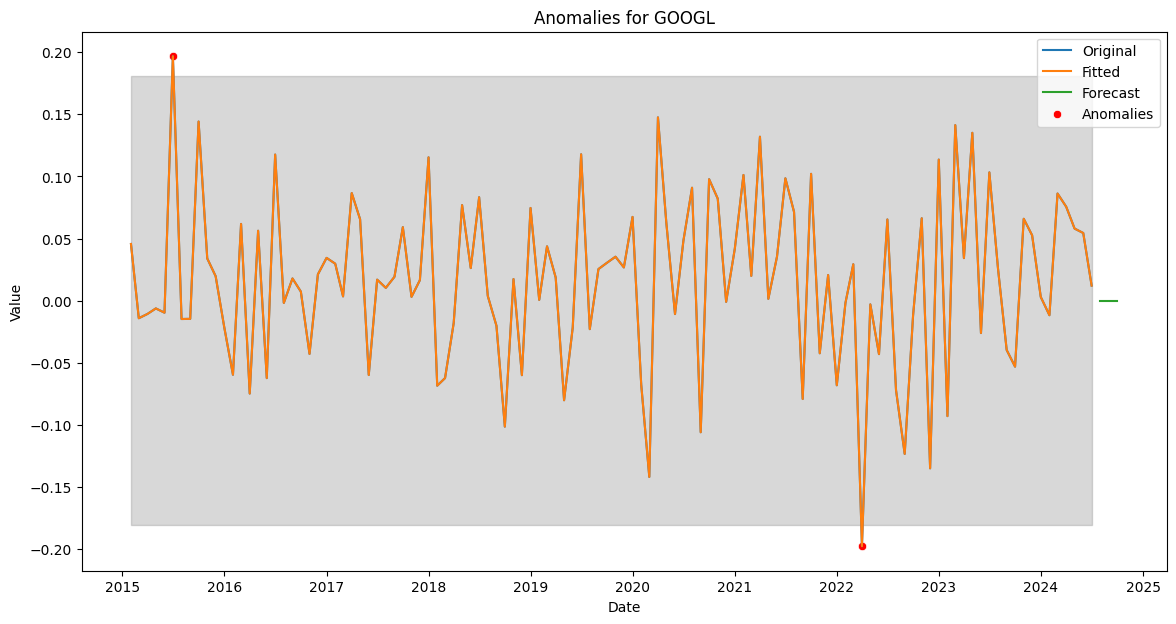

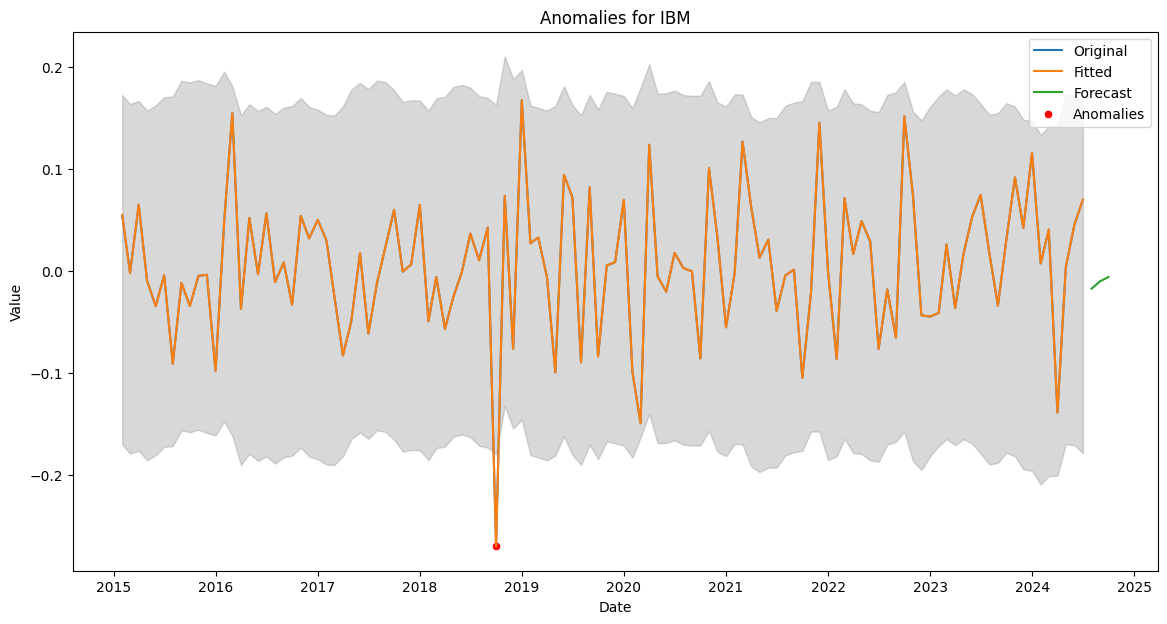

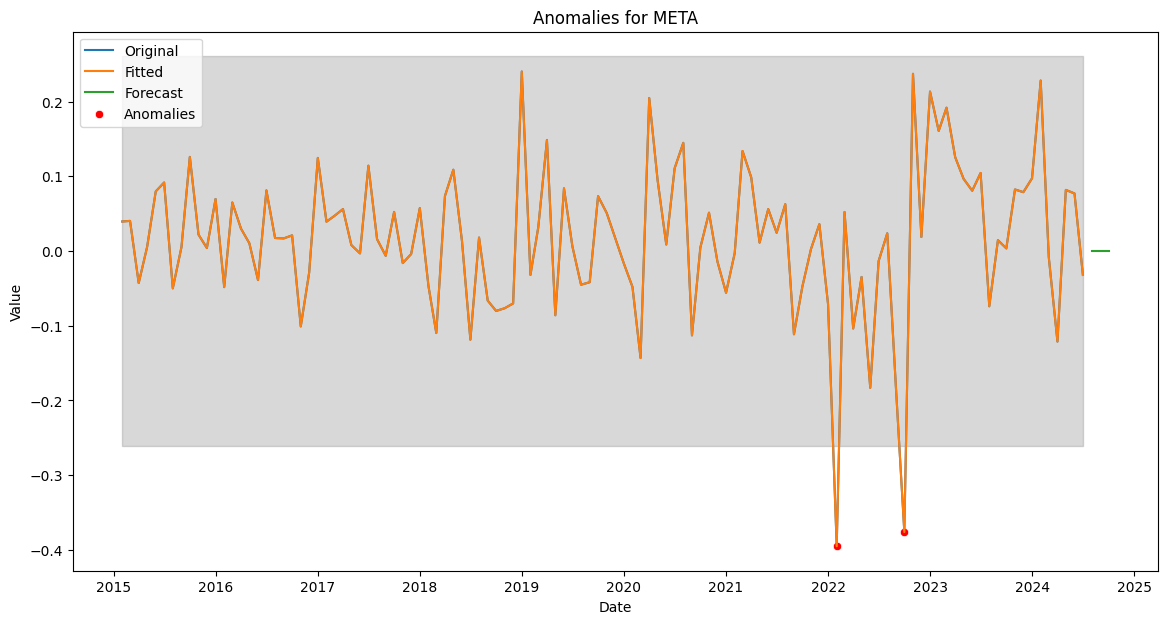

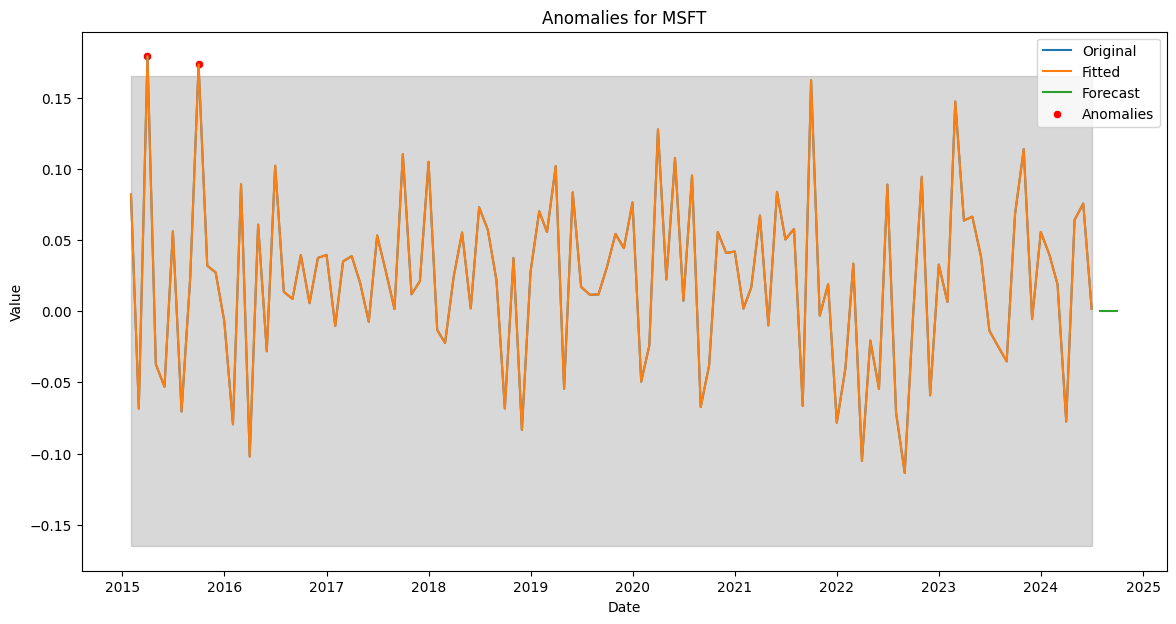

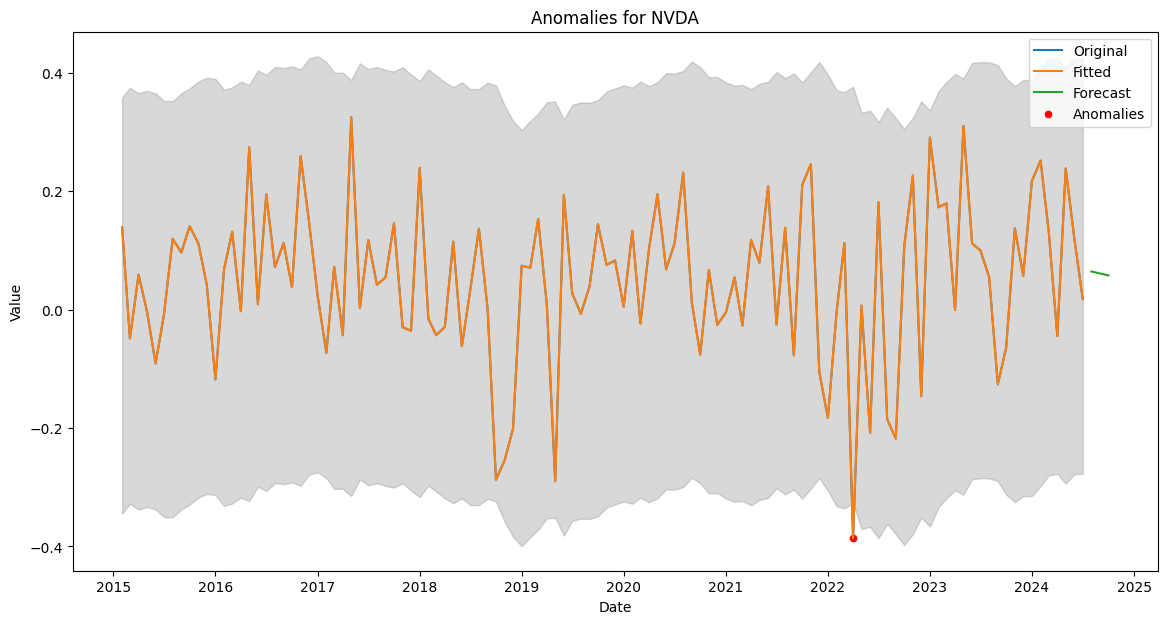

In [10]:
# Graficar resultados
unique_ids = Y_df['unique_id'].unique()

for unique_id in unique_ids:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Datos originales
    sns.lineplot(data=Y_df[Y_df['unique_id'] == unique_id], x='ds', y='y', label='Original', ax=ax)
    
    # Valores ajustados y predicciones
    sns.lineplot(data=insample_forecasts[insample_forecasts['unique_id'] == unique_id], x='ds', y='y', label='Fitted', ax=ax)
    sns.lineplot(data=fcst[fcst['unique_id'] == unique_id], x='ds', y='AutoARIMA', label='Forecast', ax=ax)
    
    # Intervalos de confianza
    ax.fill_between(
        insample_forecasts[insample_forecasts['unique_id'] == unique_id]['ds'],
        insample_forecasts[insample_forecasts['unique_id'] == unique_id]['AutoARIMA-lo-99'],
        insample_forecasts[insample_forecasts['unique_id'] == unique_id]['AutoARIMA-hi-99'],
        color='gray', alpha=0.3
    )
    
    # Marcar anomalías
    anomaly_data = anomalies[anomalies['unique_id'] == unique_id]
    sns.scatterplot(data=anomaly_data, x='ds', y='y', color='red', label='Anomalies', ax=ax)
    
    ax.set_title(f'Anomalies for {unique_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    plt.legend()
    plt.show()